Крок 1 - імпорт бібліотек , завантаження моделі та створення функції зчитування Wav файлів

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import scipy.signal
import soundfile as sf
from IPython.display import Audio, display


In [2]:
#Імпортуємо YAMNet модель
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
#зчитування WAV файлів та переведення його в зручну модель
def load_wav_16k_mono(filename):
    """Завантажити WAV-файл, перевести в моно та 16 кГц."""
    wav, sample_rate = sf.read(filename)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sample_rate != 16000:
        num_samples = int(len(wav) * 16000 / sample_rate)
        wav = scipy.signal.resample(wav, num_samples)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

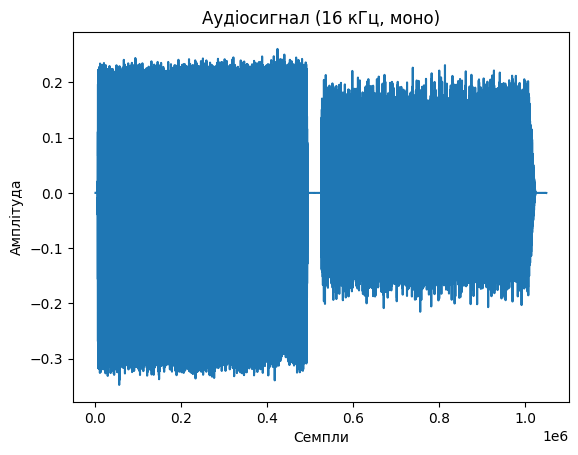

In [4]:
#Шлях до тестового файлу
filename = "D:/YAMNet1/data/sample.wav"

# Завантаження даних
testing_wav_data = load_wav_16k_mono(filename)

# Візуалізація сигналу
plt.plot(testing_wav_data.numpy())
plt.title("Аудіосигнал (16 кГц, моно)")
plt.xlabel("Семпли")
plt.ylabel("Амплітуда")
plt.show()

# Програвання аудіо
display(Audio(data=testing_wav_data.numpy(), rate=16000))

In [5]:
#Список класів у моделі
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [6]:
#Перевіряємо тестовий звук
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Electric shaver, electric razor
The embeddings shape: (136, 1024)


Модель правильно визначила, що звук видала техніка. Тепер перейдемо до другого кроку - донавчимо нашу модель звуками мотоциклів, аби вона краще їх аналізувала

In [7]:
#Завантажуємо датасет з потрібними нам даними.
DATA_DIR = {
    "motorcycle": "D:\YAMNet1\data\motorcycle",
    "background": "D:\YAMNet1\data\background"
}
print(DATA_DIR)

{'motorcycle': 'D:\\YAMNet1\\data\\motorcycle', 'background': 'D:\\YAMNet1\\data\x08ackground'}


<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\Admin\AppData\Local\Temp\ipykernel_10912\3636487337.py:3: SyntaxWarning: invalid escape sequence '\Y'
  "motorcycle": "D:\YAMNet1\data\motorcycle",
C:\Users\Admin\AppData\Local\Temp\ipykernel_10912\3636487337.py:4: SyntaxWarning: invalid escape sequence '\Y'
  "background": "D:\YAMNet1\data\background"


In [8]:
#Витягуємо ембедінги з тестових файлів
def extract_embeddings(base_dir, yamnet_model, max_files_per_class=None):
    dataset = []

    class_map = {
        "motorcycle": 1,
        "background": 0
    }

    for class_name, label in class_map.items():
        folder_path = os.path.join(base_dir, class_name)
        wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        if max_files_per_class:
            wav_files = wav_files[:max_files_per_class]

        for fname in wav_files:
            file_path = os.path.join(folder_path, fname)
            try:
                wav = load_wav_16k_mono(file_path)
                _, embeddings, _ = yamnet_model(wav)
                mean_embedding = tf.reduce_mean(embeddings, axis=0)  # [1024] вектор
                dataset.append((mean_embedding.numpy(), label))
            except Exception as e:
                print(f"Помилка з {file_path}: {e}")
    
    return dataset


In [9]:
dataset = extract_embeddings("D:/YAMNet1/data", yamnet_model)  


# Розділимо features і labels
X = np.array([x for x, _ in dataset])
y = np.array([y for _, y in dataset])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1036, 1024)
y shape: (1036,)


In [10]:
#Навчаємо нашу модель на логістичній регресії
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Розділимо на train і test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Створення та навчання моделі логістичної регресії
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Передбачення
y_pred = clf.predict(X_test)

# Оцінка результатів
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[104   1]
 [  3 100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       105
           1       0.99      0.97      0.98       103

    accuracy                           0.98       208
   macro avg       0.98      0.98      0.98       208
weighted avg       0.98      0.98      0.98       208

Accuracy: 0.9807692307692307


Крок 3 - тестування на кастомних звуках.

In [11]:

def predict_sound(file_path, yamnet_model, clf_model, class_names={0: "background", 1: "motorcycle"}):
    try:
        # Завантажити та обробити аудіо
        wav = load_wav_16k_mono(file_path)
        
        # Отримати ембедінги з YAMNet
        _, embeddings, _ = yamnet_model(wav)
        mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)
        
        # Передбачення класу
        prediction = clf_model.predict(mean_embedding)[0]
        prob = clf_model.predict_proba(mean_embedding)[0][prediction]
        
        print(f"Файл: {file_path}")
        print(f"Клас: {class_names[prediction]} (ймовірність: {prob:.2f})")
        
    except Exception as e:
        print(f"Помилка при обробці {file_path}: {e}")


In [12]:
new_file = "D:/YAMNet1/data/sample.wav"

In [13]:
predict_sound(new_file, yamnet_model, clf)

Файл: D:/YAMNet1/data/sample.wav
Клас: background (ймовірність: 0.74)
